### Pre Processing project
____

The goal is prevent churn. Prepare and perform a classification problem. By identify factors that suggest a customer will cancel their account, the inverse is also real, what promotes retaining your bank account.

The evaluation metric of interest is F1 Score, needing a score of over 0.59 on test data. F1 score is a blend of precision and recall scores. Precision is the measure/ power of your 'yes' predictions, while recall is the accuracy of 'yes' 

We will load and examine the data. Make any necessary updates to the data for performance, fill missing, encoding, and scaling.

Fit models on training data, tune on validation sets, and evaluate on test data sets. Adjustments with class weighting, handling class imbalances will be conducted separately per request.

After modeling, examine the model's justifications for classification. and compare performance metrics

Data: 

Features

RowNumber — data string index
CustomerId — unique customer identifier
Surname — surname
CreditScore — credit score
Geography — country of residence
Gender — gender
Age — age
Tenure — period of maturation for a customer’s fixed deposit (years)
Balance — account balance
NumOfProducts — number of banking products used by the customer
HasCrCard — customer has a credit card
IsActiveMember — customer’s activeness
EstimatedSalary — estimated salary

Target
Exited — сustomer has left

In [78]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
# load dataset
churn = pd.read_csv('../Churn.csv')

In [ ]:
# view dataset
print(churn.info())
print(churn.describe())
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


thoughts
___
- RowNumber is an index copy, drop it
- customerid as long as it in unique, drop it
- unless you believe surname has an affect on customer loyalty (which it might, say being of ____ origin, will make you more loyal) but we don't have that info, drop it
- geography might retain some of that loyalty logic, needs encoding
- gender same idea, needs encoding
- Tenure — period of maturation for a customer’s fixed deposit (years) not totally sure what that means yet.
- balance, we can already see some 0's
- NumOfProducts means, different services? like saving credit mortgage? not totally sure what that means yet.
- IsActive not sure how this is the difference from exited, but from the first 5 rows i can see they don't have the same meaning.
- exited? is the target feature

In [ ]:
# Exited is the target feature, what are it's values
churn['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

thoughts
___
4:1 can use some assistance

In [ ]:
# is customer id unique? if it is unique then it is basically another index column. if == 10000, drop
churn['CustomerId'].nunique()

10000

In [ ]:
# remove unnecessary columns
churn = churn.drop(columns=['CustomerId', 'RowNumber', 'Surname'])

### Missing data
___
Tenure has some missing values. research says Tenure is an agreement you can make with a bank, where basically saying 'I will not withdraw this money for this long'. They are kind of like cd's and are sometimes used as loan collateral. Missing values could be filled with 0's

In [7]:
# fill missing
churn = churn.fillna(0)

### Encoding
___
Several features need to be encoded. 
- Gender - label encoding
- Geography, number of products - one hot encoding

In [8]:
churn['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [9]:
churn['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

thoughts
___
gender can be encoded with label encoding, and geography can be one hot encoded

In [ ]:
# label encode the genre column with mapping
churn['Gender'] = churn['Gender'].map({'Male': 0, 'Female': 1})

In [ ]:
# One Hot Encode the geography feature

# initialize the encoder
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(churn[['Geography']]).toarray()

# get the categories for geography column
categories = encoder.categories_[0]

# retrieve name values for column names
new_columns = [f'Geography_{cat}' for cat in categories]
churn_encoded = pd.DataFrame(encoded_data, columns=new_columns)

# merge new columns
churn = pd.concat([churn, churn_encoded], axis=1)

# remove old column
churn.drop('Geography', axis=1, inplace=True)

In [ ]:
# One Hot Encode the Num Of Products feature

# initialize the encoder
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(churn[['NumOfProducts']]).toarray()

# get the categories for geography column
categories = encoder.categories_[0]

# retrieve name values for column names
new_columns = [f'NumOfProducts_{cat}' for cat in categories]
churn_encoded = pd.DataFrame(encoded_data, columns=new_columns)

# merge new columns
churn = pd.concat([churn, churn_encoded], axis=1)

# remove old column
churn.drop('NumOfProducts', axis=1, inplace=True)

I decided to not 'drop first', the models we will be using are good at weighting features including ignoring a feature all together.

### Train test split
____
Now that our features are encoded. It is time to split the data in order to train models

In [ ]:
# split off the target feature to hide it from the model
features = churn.drop('Exited', axis=1)
target = churn['Exited']

In [ ]:
# split training set from valid / test (60:40), including stratify to make sure the target feature is split evenly between training and test sets
feature_train, feature_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=36)

# split valid and test sets 50:50 for an ultimate split of 60:20:20
feature_valid, feature_test, target_valid, target_test = train_test_split(
    feature_temp, target_temp, test_size=0.5, stratify=target_temp, random_state=36)

### Distributions
___
We may need to scale data depending on performance of models. How we will scale them depends on their distributions, standard scaler is better at normal-ish distributions, minmaxscaler is good for features with a fixed range, and robust scaler is great with outliers

In [16]:
# tenure, ordinal variable - discrete variable where the order has meaning
churn.groupby('Tenure')['Exited'].count()

Tenure
0.0     1291
1.0      952
2.0      950
3.0      928
4.0      885
5.0      927
6.0      881
7.0      925
8.0      933
9.0      882
10.0     446
Name: Exited, dtype: int64

thoughts
___
There actually isn't as much drop off as I expected. However good job to the bank on having the largest category be under 1 year.

In [17]:
# estimated salary, continuous variable
fig = px.histogram(churn,
                   x='EstimatedSalary',
                   nbins=100,
                   title='Distribution of customer estimated salaries')
fig.show()

thoughts
___
Great, appears to be no skew in salary

In [18]:
# visualize to look for skew
fig = px.histogram(churn,
                   x='Balance',
                   nbins=100,
                   title='Distribution of account balances')
fig.show()

thoughts
____
Ha... incredibly normal with ~3500 0-balances. Are exited accounts over represented in empty accounts?

In [19]:
print('zero balance exited count: ',
      churn[churn['Balance'] == 0]['Exited'].sum())
print('zero balance not-exited count: ',
      (churn[churn['Balance'] == 0]['Exited'].count()) - churn[churn['Balance'] == 0]['Exited'].sum())
print('Non-zero balance exited count: ',
      churn[churn['Balance'] != 0]['Exited'].sum())
print('total exited: ', churn['Exited'].sum())

zero balance exited count:  500
zero balance not-exited count:  3117
Non-zero balance exited count:  1537
total exited:  2037


thoughts
____
- 20% of all data have exited (10000)
- 1/6 of $0 accounts have exited. Actually under represented

In [ ]:
# assign columns to be scaled
standard_col = ['EstimatedSalary', 'Balance']
min_max_col = ['CreditScore', 'Age', 'Tenure']

# create scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# fit and transform the interested columns

# standard scaler
# train
feature_train[standard_col] = scaler_standard.fit_transform(
    feature_train[standard_col])
# valid
feature_valid[standard_col] = scaler_standard.transform(
    feature_valid[standard_col])
# test
feature_test[standard_col] = scaler_standard.transform(
    feature_test[standard_col])

# min max scaler
# train
feature_train[min_max_col] = scaler_minmax.fit_transform(
    feature_train[min_max_col])
# valid
feature_valid[min_max_col] = scaler_minmax.transform(
    feature_valid[min_max_col])
# test
feature_test[min_max_col] = scaler_minmax.transform(feature_test[min_max_col])

### Modeling
___
We are going to train models, then introduce class balancing using model weighting and downsampling

In [21]:
# Logistic Regression for f1 score

# params
regulation = ['l2', 'l1']
c = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

best_model = None
best_result = 0

for reg in regulation:
    for cc in c:
        log_reg = LogisticRegression(penalty=reg,
                                     C=cc,
                                     solver='liblinear',
                                     random_state=36)

        log_reg.fit(feature_train, target_train)
        valid_pred = log_reg.predict(feature_valid)
        res = f1_score(target_valid, valid_pred)

        if res > best_result:
            best_result = res
            best_model = log_reg
            best_reg = reg

print('best model', best_model)
print('best result', best_result)
print('best reg', reg)

best model LogisticRegression(C=2.0, penalty='l1', random_state=36, solver='liblinear')
best result 0.4937106918238994
best reg l1


thoughts
____
unbalanced f1 score is not good, it is lasso, so most likely the features we didnt drop in one hot encoding were dropped/ ignored

In [30]:
# Logistic Regression - with class_weight = 'balanced', everything else is the same

# params
regulation = ['l2', 'l1']
c = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

best_model = None
best_result = 0

for reg in regulation:
    for cc in c:
        log_reg = LogisticRegression(penalty=reg,
                                     C=cc,
                                     solver='liblinear',
                                     class_weight='balanced',
                                     random_state=36)

        log_reg.fit(feature_train, target_train)
        valid_pred = log_reg.predict(feature_valid)
        res = f1_score(target_valid, valid_pred)

        if res > best_result:
            best_result = res
            best_model = log_reg
            best_reg = reg

print('best model', best_model)
print('best result', best_result)
print('best reg', reg)

best model LogisticRegression(C=5.0, class_weight='balanced', random_state=36,
                   solver='liblinear')
best result 0.5402405180388529
best reg l1


thoughts
____
The model improved from 0.49 to 0.54, that's great

In [ ]:
# show the feature weights
weights = log_reg.coef_[0]

# features names
feature_names = features.columns

# plot of weighting
plt.figure(figsize=(10, 6))
plt.bar(feature_names, weights)
plt.xlabel("Features")
plt.xticks(rotation=65)
plt.ylabel("Weight")
plt.title("Feature weights from logistic regression (L1 Penalty)")
plt.tight_layout()
plt.show()

thoughts
___
Class weighting has adjusted the faeture weights as well. Now being in germany is correlated to leaving, and age increased

In [ ]:
# test data
log_reg_test = LogisticRegression(C=5.0,
                                  class_weight='balanced',
                                  solver='liblinear',
                                  penalty='l1',
                                  random_state=36
                                  )
log_reg_test.fit(feature_train, target_train)
y_pred = log_reg_test.predict(feature_test)
print('f1 score: ', f1_score(target_test, y_pred))

f1 score:  0.5849731663685152


Test score is better than the valid set, but still not the success criteria.

In [34]:
# upsampling
# take training datasets and make them match in quantity

feature_zeros = feature_train[target_train == 0]
feature_ones = feature_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(
    f'length of zeros: {len(feature_zeros)}  length of ones: {len(feature_ones)}')

length of zeros: 4778  length of ones: 1222


In [51]:
# almost 1:4, because overfitting is the worry with upsampling, we will use 3
feature_upsample = pd.concat(
    [feature_zeros, feature_ones, feature_ones, feature_ones], ignore_index=True)
target_upsample = pd.concat(
    [target_zeros, target_ones, target_ones, target_ones], ignore_index=True)

In [52]:
# shuffle the data
feat_upsamp, targ_upsamp = shuffle(
    feature_upsample, target_upsample, random_state=36)

In [ ]:
# Logistic Regression - with upsampled data, no class_weight

# params
regulation = ['l2', 'l1']
c = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
     8.0, 9.0, 10.0, 11.0, 12.0]

best_model = None
best_result = 0

for reg in regulation:
    for cc in c:
        log_reg = LogisticRegression(penalty=reg,
                                     C=cc,
                                     solver='liblinear',
                                     random_state=36)

        log_reg.fit(feat_upsamp, targ_upsamp)
        valid_pred = log_reg.predict(feature_valid)
        res = f1_score(target_valid, valid_pred)

        if res > best_result:
            best_result = res
            best_model = log_reg
            best_reg = reg
            best_c = cc

print('best model', best_model)
print('best result', best_result)
print('best reg', reg)
print('best C', cc)

best model LogisticRegression(penalty='l1', random_state=36, solver='liblinear')
best result 0.5556711758584808
best reg l1
best C 15.0


In [59]:
# test data
log_reg_test = LogisticRegression(C=12.0,
                                  solver='liblinear',
                                  penalty='l1',
                                  random_state=36
                                  )
log_reg_test.fit(feat_upsamp, targ_upsamp)
y_pred = log_reg_test.predict(feature_test)
print('f1 score: ', f1_score(target_test, y_pred))

f1 score:  0.5978152929493545


thoughts
___
upsampling increased the test f1 score to 0.598 which is slightly in the success zone 

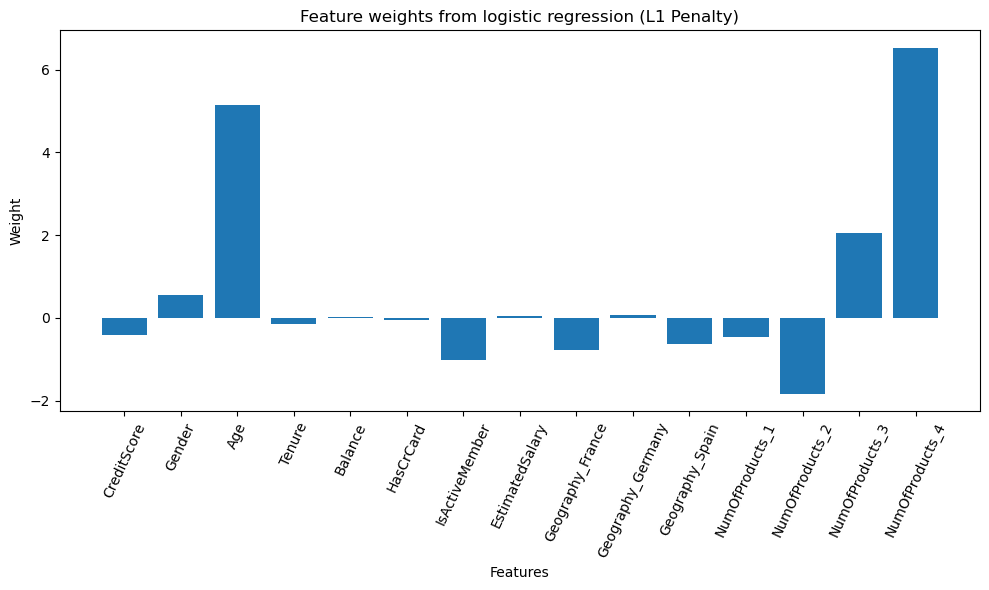

In [63]:
# show the feature weights
weights = log_reg_test.coef_[0]

# features names
feature_names = features.columns

# plot of weighting
plt.figure(figsize=(10, 6))
plt.bar(feature_names, weights)
plt.xlabel("Features")
plt.xticks(rotation=65)
plt.ylabel("Weight")
plt.title("Feature weights from logistic regression (L1 Penalty)")
plt.tight_layout()
plt.show()

thoughts
____
Gender, age, and utilizing 3 or 4 products are positively correlated with the '1' group or exiting the bank. Especially age and 4 products used.

The more products you have the more likely you are to close your account. At first that is confusing but customers who use the bank more, or are more knowledgeable of bank offerings, the more you use the bank the more critical you might become? Also age, older more likely to change banks, older people tend to have more money

Two or one products more likely to stay. Simple banking = longevity

Logistic Regression AUC-ROC: 0.8493693959996057


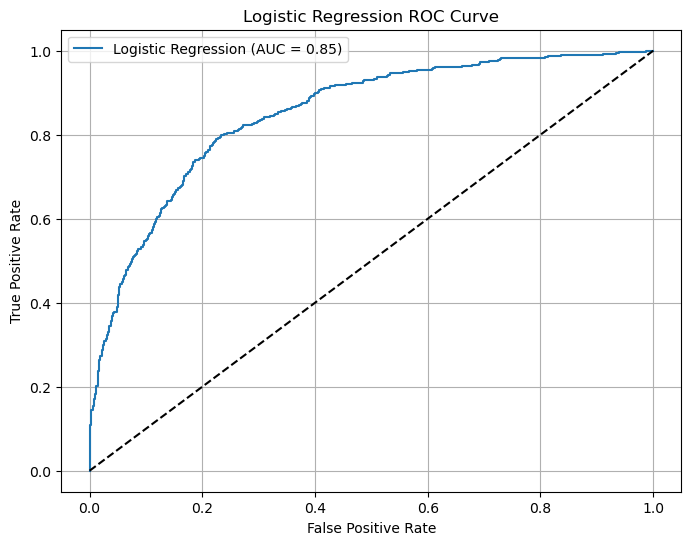

In [81]:
# ROC for logistic regression
# probabilities for '1' class
lr_probs = log_reg_test.predict_proba(feature_test)[:, 1]

# ROC score
lr_auc = roc_auc_score(target_test, lr_probs)

print(f"Logistic Regression AUC-ROC: {lr_auc}")

# ROC curve
plt.figure(figsize=(8, 6))
lr_fpr, lr_tpr, _ = roc_curve(target_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")

# random model line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

thoughts
___
Actually pretty good, f1 is still only 0.598

In [61]:
# random forest classifier -  no weighting
best_model = None
best_result = 0

criterion = ['gini', 'entropy']

for est in range(10, 101, 10):
    for depth in range(1, 15):
        for crit in criterion:
            rand_forest = RandomForestClassifier(
                n_estimators=est, max_depth=depth, criterion=crit, random_state=36)
            rand_forest.fit(feature_train, target_train)
            valid_pred = rand_forest.predict(feature_valid)
            result = f1_score(target_valid, valid_pred)
            if result > best_result:
                best_result = result
                best_model = rand_forest
                criter = crit


print('best model', best_model)
print('best result', best_result)
print('criterion', criter)

best model RandomForestClassifier(max_depth=12, n_estimators=30, random_state=36)
best result 0.5796661608497724
criterion gini


thoughts
___
Better starting place.

In [ ]:
# random forest classifier - class weighting
best_model = None
best_result = 0

criterion = ['gini', 'entropy']

for est in range(10, 101, 10):
    for depth in range(1, 15):
        for crit in criterion:
            rand_forest = RandomForestClassifier(
                n_estimators=est, max_depth=depth, criterion=crit, class_weight='balanced', random_state=36)
            rand_forest.fit(feature_train, target_train)
            valid_pred = rand_forest.predict(feature_valid)
            result = f1_score(target_valid, valid_pred)
            if result > best_result:
                best_result = result
                best_model = rand_forest
                criter = crit
                best_est = est


print('best model', best_model)
print('best result', best_result)
print('criterion', criter)
print('best est ', best_est)

best model RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=120,
                       random_state=36)
best result 0.6212471131639723
criterion gini
best est  120


thoughts
____
Even better

In [ ]:
# random forest classifier - upsampling
best_result = 0

criterion = ['gini', 'entropy']

for est in range(10, 101, 10):
    for depth in range(1, 15):
        for crit in criterion:
            rand_forest = RandomForestClassifier(
                n_estimators=est, max_depth=depth, criterion=crit, random_state=36)
            rand_forest.fit(feat_upsamp, targ_upsamp)
            valid_pred = rand_forest.predict(feature_valid)
            result = f1_score(target_valid, valid_pred)
            if result > best_result:
                best_result = result
                best_model = rand_forest
                criter = crit
                best_est = est


print('best model', best_model)
print('best result', best_result)
print('criterion', criter)
print('best est ', best_est)

best model RandomForestClassifier(max_depth=9, n_estimators=80, random_state=36)
best result 0.6239620403321471
criterion gini


thoughts
___
slightly better is still better.

In [83]:
# random forest test
rand_forest_test = RandomForestClassifier(n_estimators=80,
                                          max_depth=9,
                                          criterion='gini',
                                          random_state=36)
rand_forest_test.fit(feat_upsamp, targ_upsamp)
test_pred = rand_forest_test.predict(feature_test)
print(f1_score(target_test, test_pred))

0.6279863481228669


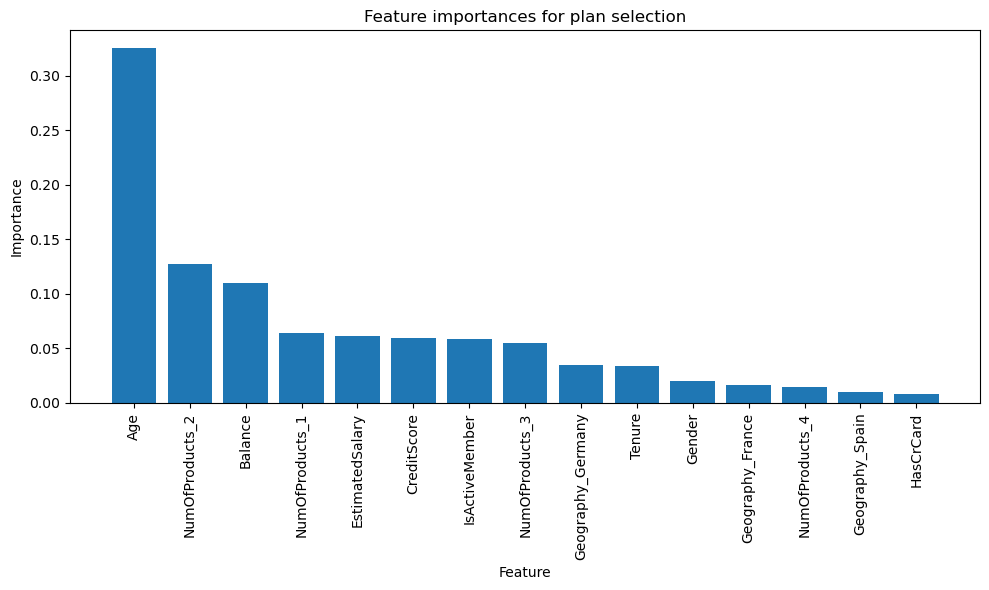

In [84]:
# random forest

# feature importance for random forest classifier
feature_importances = rand_forest_test.feature_importances_

# sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances for plan selection")
plt.bar(range(feature_train.shape[1]), feature_importances[indices])
plt.xticks(range(feature_train.shape[1]), feature_names[indices],
           rotation=90)  # Replace feature_names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

thoughts
___
Age is the single best feature

Random Forest AUC-ROC: 0.8720178712188392


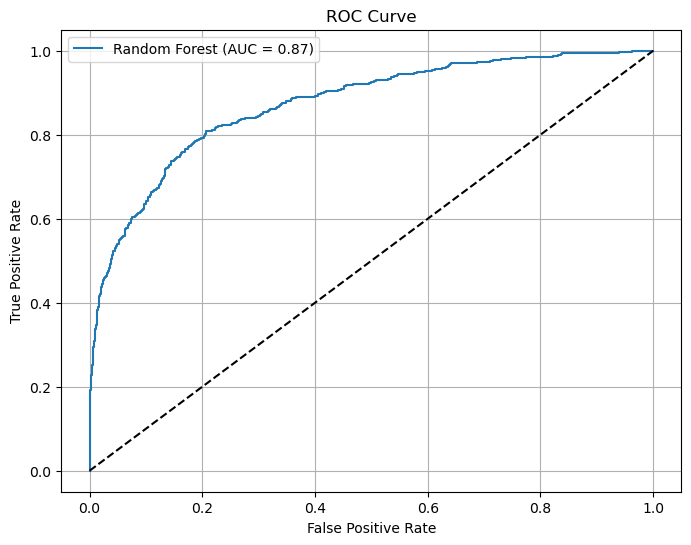

In [86]:
# random forest ROC
# positive class probabilities
rf_probs = rand_forest_test.predict_proba(feature_test)[:, 1]

# roc score
rf_auc = roc_auc_score(target_test, rf_probs)

print(f"Random Forest AUC-ROC: {rf_auc}")

# roc curve
plt.figure(figsize=(8, 6))

rf_fpr, rf_tpr, _ = roc_curve(target_test, rf_probs)

plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

# random model line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

thoughts
___
slightly higher than log regression which makes sense. The f1 score was also slightly higher

### conclusion
___
The random forest classifier narrowly edged out logistic regression. 
f1 score: 0.623  v. f1 score:  0.598
the models told us that customers who use more banking products (3 or 4) were more likely to leave the bank. Both models suggested that Age was an important feature for prediction. Logistic regression told us age has a positive correlation to exiting the bank. 

model based speculation:
I believe that customers who are more educated in money are more likely to change banks. Supressing financial literacy sounds evil, but it could prevent customers leaving.

Suggestions:
These models gave us a hint at who might want to switch banks, it didn't tell us why. Perhaps as customers get more knowledgeable or have more money simply use the bank more and are annoyed with trivial things like business hours. I believe the next steps to take are talk to your customers. Targeting the responses of the vulnerable clients (older, use more products etc.) for actionable solutions.

future improvements
Perhaps build a model for specific cohorts of customers. $0 balance get model A while the rest get model B. Different encoding practices. perhaps binning salaries, or ages could gain greater insights into which group is the most vulnerable.
